In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import GEMS
import os
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import ttest_ind as ttest
from sklearn.decomposition import PCA
from scipy import stats 
from matplotlib import gridspec
from statsmodels.stats.multitest import multipletests
import matplotlib.cm as cm
import etcpy
from functools import reduce

In [2]:
dfae_batch,dfan_batch =GEMS.load_exp_batch_data('../data/ExpGrowth.tsv')
dfchemo = pd.read_csv('../data/Chemostat_exp_data.txt',sep='\t',index_col=0)

In [3]:
def boot_strap_ci(data,sampling_time=1000):
    # data is a matrix, we are going to get cis for all columns
    data = np.array(data)
    def _ci_of_a_column(lst):
        means = []
        for _ in range(sampling_time):
            sampled_index = np.random.randint(0,len(lst),size=len(lst)) 
            means.append(np.mean(lst[sampled_index]))
        means.sort()
        return [means[24],means[974]]
    
    cis = list()
    for i in range(data.shape[1]):
        cis.append(_ci_of_a_column(data[:,i]))
    
    return np.array(cis)

In [4]:
!less ../data/enzyme_uniprot_gene_name.csv|grep ADE5

P07244,ADE5,7


In [5]:
def load_gene_names():
    gene_names = dict()
    gene_ids = dict()
    for line in open('../data/enzyme_uniprot_gene_name.csv'):
        cont = line.strip().split(',')
        gene_names[cont[0]] = cont[1]
        gene_ids[cont[1]] = cont[0]
    return gene_names,gene_ids

### Visualize models from posterior distribution

In [132]:
model_file_paths = (f'../results/smcabc_gem_three_conditions_permuted_{i}_save_all_particles.pkl' for i in range(3))

In [133]:
models = [pickle.load(open(file_path,'rb')) for file_path in model_file_paths]

In [134]:
def plot_lines_prior_ae(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfae_batch.index,dfae_batch['r_ae'],color='k',label='experimental',zorder=1)
    print(np.var(dfae_batch['r_ae'])*0.15)
    
    for item in model.simulated_data_t0: 
        plt.plot(dfae_batch.index,item['rae'],color='#1f78b4',zorder=0)

    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Aerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [135]:
def plot_lines_prior_an(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfan_batch.index,dfan_batch['r_an'],color='k',label='experimental',zorder=1)
    
    ts = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
    for item in model.simulated_data_t0: 
        plt.plot(ts,item['ran'],zorder=0,color='#1f78b4')
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Anaerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Anaerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [136]:
def plot_lines_prior_chemostat(model,prefix=None):
    sns.set_style("ticks")
    
    rs0 = []
    for item in model.simulated_data_t0: rs0.append(item['chemostat'])

    #rs0 = np.array(rs0)
    
    cols = ['Glucose','CO2','Ethanol']
    titles = ['Glucose','CO$_2$','Ethanol']
    
    print(np.var(dfchemo[cols].values)*0.15)
    for i in range(3):
        if i<2: continue
        plt.figure(figsize=(3,2.4))
        plt.scatter(dfchemo.index,dfchemo[cols[i]],color='k',label='experimental',zorder=1)
        for j,r in enumerate(rs0):
            plt.plot(dfchemo.index,r[i*6:(i+1)*6],color='#1f78b4',zorder=0)
        print(j)
        plt.xlabel('Temperature ($^\circ$C)')
        plt.ylabel('{0}'.format(titles[i])+' (mmol gDW$^{-1}$ h$^{-1}$)')
        plt.ylim((-1,18))
        #plt.legend(loc='upper left',fontsize=8)
        #plt.title(titles[i])
        plt.tight_layout()
        if prefix is not None: plt.savefig(prefix+'_{0}.pdf'.format(cols[i]))
        plt.show()

0.0018241406250000005


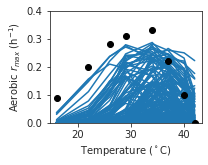

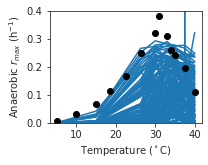

4.260765416666666
143


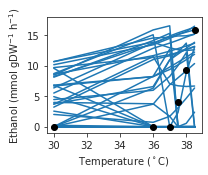

0.0018241406250000005


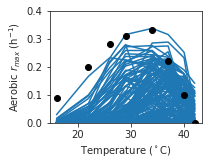

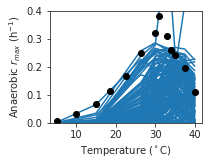

4.260765416666666
143


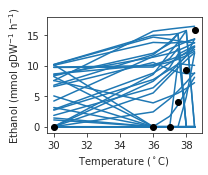

0.0018241406250000005


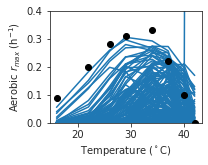

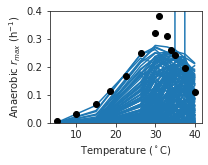

4.260765416666666
143


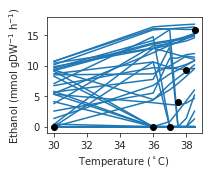

In [139]:
for model in models:
    plot_lines_prior_ae(model)
    plot_lines_prior_an(model)
    plot_lines_prior_chemostat(model)

In [140]:
!pwd

/mnt/scratch/jakobpp/BayesianGEM/code


In [141]:
def plot_last_population_ae(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfae_batch.index,dfae_batch['r_ae'],color='k',label='experimental')
    print(np.var(dfae_batch['r_ae'])*0.15)
    
    rs0 = list()
    rs  = list()
    for item in model.simulated_data_t0: rs0.append(item['rae'])
    for item in model.simulated_data: rs.append(item['rae'])

    rs0 = np.array(rs0)
    y0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    y = np.percentile(rs,[5,50,95],axis=0)
    
    
    plt.plot(dfae_batch.index,y0[1,:],color='#1f78b4',label='prior')
    plt.fill_between(dfae_batch.index,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
    
    plt.plot(dfae_batch.index,y[1,:],color='#fc8d59',label='posterior')
    plt.fill_between(dfae_batch.index,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
    
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Aerobic $r_{max}$ (h$^{-1}$)')
    plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Aerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [142]:
def plot_last_population_an(model,outname=None):
    sns.set_style("ticks")
    plt.figure(figsize=(3,2.4))
    plt.scatter(dfan_batch.index,dfan_batch['r_an'],color='k',label='experimental')
    
    
    rs0 = list() # prior
    rs = list()  # posterior
    for item in model.simulated_data: rs.append(item['ran'])
    for item in model.simulated_data_t0:rs0.append(item['ran'])
    ts = [5.0,15.0,26.3,30.0,33.0,35.0,37.5,40.0]
    print(np.var(dfan_batch.loc[ts,'r_an'])*0.15)
    
    rs0 = np.array(rs0)
    y0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    y = np.percentile(rs,[5,50,95],axis=0)
    
    plt.plot(ts,y0[1,:],color='#1f78b4',label='prior')
    plt.fill_between(ts,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
    
    plt.plot(ts,y[1,:],color='#fc8d59',label='posterior')
    plt.fill_between(ts,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
    
    plt.xlabel('Temperature ($^\circ$C)')
    #plt.ylabel('Maximal specific growth rate (h$^{-1}$)')
    plt.ylabel('Anaerobic $r_{max}$ (h$^{-1}$)')
    #plt.ylim((0,0.4))
    #plt.legend(loc='upper left',fontsize=8)
    #plt.title('Anaerobic growth')
    plt.tight_layout()
    if outname is not None: plt.savefig(outname)
    plt.show()

In [143]:
def plot_last_population_chemostat(model,prefix=None):
    sns.set_style("ticks")
    
    rs0 = []
    rs  = []
    for item in model.simulated_data_t0: rs0.append(item['chemostat'])
    for item in model.simulated_data: rs.append(item['chemostat'])

    #rs0 = np.array(rs0)
    #yt0 = np.mean(rs0,axis=0)
    #yerrt0 = np.std(rs0,axis=0)
    
    #rs = np.array(rs)
    #yt = np.mean(rs,axis=0)
    #yerrt = np.std(rs,axis=0)
    rs0 = np.array(rs0)
    yt0 = np.percentile(rs0,[5,50,95],axis=0)
    
    rs = np.array(rs)
    yt = np.percentile(rs,[5,50,95],axis=0)
    
    cols = ['Glucose','CO2','Ethanol']
    titles = ['Glucose','CO$_2$','Ethanol']
    print(np.var(dfchemo[cols].values)*0.15)
    for i in range(3):
        plt.figure(figsize=(3,2.4))
        plt.scatter(dfchemo.index,dfchemo[cols[i]],color='k',label='experimental')
        y0 = yt0[:,i*6:(i+1)*6]
        #yerr0 = yerrt0[i*6:(i+1)*6]
        plt.plot(dfchemo.index,y0[1,:],color='#1f78b4',label='prior')
        plt.fill_between(dfchemo.index,y0[0,:],y0[2,:],alpha=0.8,color='#1f78b4')
        
        y = yt[:,i*6:(i+1)*6]
        #yerr = yerrt[i*6:(i+1)*6]
        plt.plot(dfchemo.index,y[1,:],color='#fc8d59',label='posterior')
        plt.fill_between(dfchemo.index,y[0,:],y[2,:],alpha=0.8,color='#fc8d59')
        
        plt.xlabel('Temperature ($^\circ$C)')
        plt.ylabel('{0}'.format(titles[i])+' (mmol gDW$^{-1}$ h$^{-1}$)')
        plt.ylim((-1,18))
        #plt.legend(loc='upper left',fontsize=8)
        #plt.title(titles[i])
        plt.tight_layout()
        if prefix is not None: plt.savefig(prefix+'_{0}.pdf'.format(cols[i]))
        plt.show()

In [144]:
def plot_legend_growth():
    plt.figure(figsize=(3,2.4))
    plt.scatter([],[],color='k',label='Exp')
    
    plt.plot([],[],color='#1f78b4',label='Prior')
    plt.fill_between([],[],[],alpha=0.8,color='#1f78b4')
    
    plt.plot([],[],color='#fc8d59',label='Posterior')
    plt.fill_between([],[],[],alpha=0.8,color='#fc8d59')
    
    plt.legend(loc='center')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('../figures/prior_posterior_legend.pdf',transparent=True)
    plt.show()

0.0018241406250000005


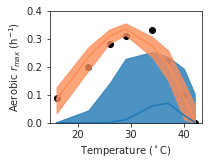

0.0017126156249999997


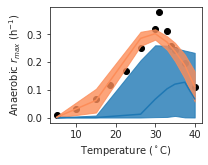

4.260765416666666


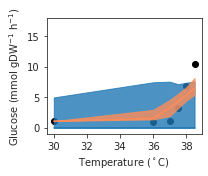

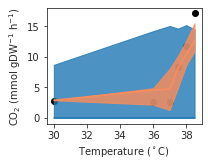

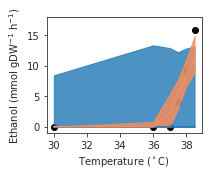

0.0018241406250000005


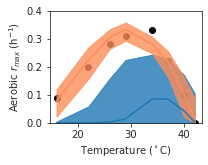

0.0017126156249999997


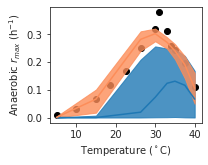

4.260765416666666


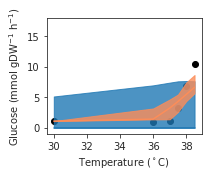

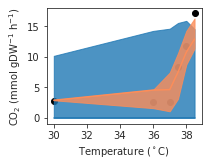

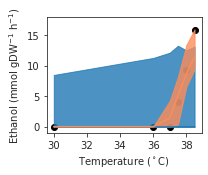

0.0018241406250000005


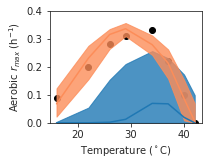

0.0017126156249999997


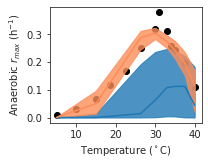

4.260765416666666


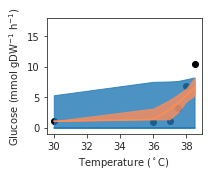

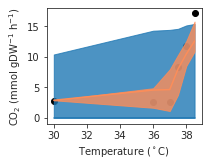

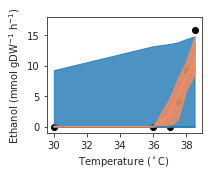

In [145]:
for model in models:
    plot_last_population_ae(model)
    plot_last_population_an(model)
    plot_last_population_chemostat(model)
    

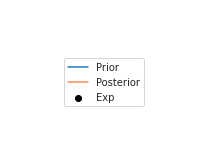

In [146]:
 plot_legend_growth()

### Visualize particle population

In [147]:
def build_a_dataframe_for_all_particles(results):
    columns = list(results.all_particles[0].keys())
    columns.sort()

    data = list()
    for p in results.all_particles:
        data.append([p[k] for k in columns])
    df = pd.DataFrame(data=data,columns=columns)
    df['r2'] = results.all_distances
    print(df.shape)
    
    # Remove samples with a R2 score smaller than -3
    df['r2'] = -df['r2']
    sel_index = df.index[df['r2']>-3]
    df = df.loc[sel_index,:]
    print(df.shape)

    return df

In [189]:
def combine_dataframes_for_models(df_dict):
    # augmented_df_list =[ df.assign(model = lambda df: label)  for df, label in zip(df_list, index)]
    augmented_df_dict = {label: df.copy() for label, df in df_dict.items()}
    print("Copying done")
    for label, df in augmented_df_dict.items():
        df["model"] = label
        df["period"] = "Intermediate"
        df.loc[:128,"period"] = "Prior"
        df.loc[df["r2"] > 0.9,"period"] = 'Posterior'
        df.reset_index()
    print("Labelling done")
    return pd.concat(augmented_df_dict.values(), ignore_index=True)
    

In [149]:
def perform_pca_on_parameters(df):
    # 1. normalize all columns to a standard normal distribution
    X, y, model, period = df.values[:,:-3], df.values[:,-3], df.values[:,-2], df.values[:,-1]
    X_n = np.zeros_like(X)    
    for i in range(X_n.shape[1]): X_n[:,i] = (X[:,i]-np.mean(X[:,i]))/np.std(X[:,i])
    pca = PCA(n_components=2)
    PCS = pca.fit_transform(X_n)
    print(pca.explained_variance_ratio_)
    return PCS,pca.explained_variance_ratio_

In [150]:
reference_model = pickle.load(open("../results/smcabc_gem_three_conditions_save_all_particles.pkl",'rb'))

In [151]:
[reference_model].extend(models)

In [179]:
combined_list = [reference_model]
combined_list.extend(models)
combined_index = ['prior']
combined_index.extend((f'permuted_{i}') for i in range(3))
combined_df_dict = {label: build_a_dataframe_for_all_particles(result) for result, label in zip(combined_list, combined_index)}

(107904, 2293)
(107458, 2293)
(14400, 2293)
(14178, 2293)
(14399, 2293)
(14191, 2293)
(14400, 2293)
(14174, 2293)


In [186]:
combined_df_dict['permuted_1']

,O13525_Tm,O13525_Topt,O13525_dCpt,P00044_Tm,P00044_Topt,P00044_dCpt,P00045_Tm,P00045_Topt,P00045_dCpt,P00127_Tm,...,Q99258_Tm,Q99258_Topt,Q99258_dCpt,Q99312_Tm,Q99312_Topt,Q99312_dCpt,Q99321_Tm,Q99321_Topt,Q99321_dCpt,r2
0,315.891153,275.831838,-8481.534649,325.577253,308.438360,-4702.365993,317.831525,283.945531,-7211.721639,321.047686,...,324.484879,306.503978,-4877.254598,326.414654,306.743296,-3867.434765,325.118341,316.844245,-7235.050550,-0.080556
1,323.224711,313.370065,-4992.316476,328.031300,278.073781,-4793.033406,314.937789,307.809157,-9521.183607,324.042887,...,324.897739,306.930823,-4583.937904,322.243997,309.465973,-6731.814506,320.937953,294.632899,-8562.896444,0.221849
2,329.194548,324.972757,-10864.791167,324.756528,321.972754,-10790.620517,327.731270,279.866721,-2986.591519,322.312690,...,334.254075,308.638882,-6442.706400,327.548148,308.076779,-6065.888887,321.988051,293.493738,-7462.409346,-1.985033
3,330.925907,303.193096,-5801.540065,323.215150,311.903829,-6373.777268,316.459018,296.508734,-5461.554808,327.909768,...,333.514674,308.965286,-6592.320059,330.866416,305.647933,-9138.490719,332.543978,307.113938,-2135.706774,-1.358355
4,335.001353,311.000605,-5745.012708,324.480663,310.761854,-3032.529831,324.282021,296.365744,-4424.505100,331.605358,...,328.881298,285.100694,-7958.543087,328.469181,324.096075,-5480.838805,320.612712,289.327618,-5748.549851,-1.710589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14394,320.766246,304.201689,-7230.131531,321.808176,310.964279,-6478.462898,322.003619,282.003107,-6144.574075,335.803199,...,328.227177,317.436033,-6775.888066,327.965322,295.442515,-3815.247038,325.438860,298.358290,-4449.761198,0.432346
14395,319.085789,287.392044,-7308.860774,328.784063,303.926115,-2316.394850,325.968985,306.019628,-7538.766657,336.313973,...,324.012938,296.131847,-7564.649026,320.606495,310.388559,-6798.484702,321.323247,299.074252,-6971.789872,0.301428
14396,321.051815,287.472554,-6427.724794,325.327752,305.794858,-7706.049527,324.610283,296.194610,-8827.918440,326.893220,...,324.587005,300.314775,-5968.090790,320.034124,312.921629,-5283.119188,324.447006,296.017704,-8290.854296,-0.379699
14397,326.606219,315.991469,-4673.554878,323.360832,297.985631,-5611.531380,329.994250,295.783078,-6395.208713,337.146691,...,328.935455,310.141270,-5316.958232,322.686915,299.952024,-2594.751911,327.297191,296.841974,-4609.011089,0.215597


In [190]:
combined_df = combine_dataframes_for_models(combined_df_dict)

Copying done
Labelling done


In [191]:
# pickle.dump(combined_df,open("../results/combined_permuted_df.pkl", 'wb'))

In [192]:
combined_df

,O13525_Tm,O13525_Topt,O13525_dCpt,P00044_Tm,P00044_Topt,P00044_dCpt,P00045_Tm,P00045_Topt,P00045_dCpt,P00127_Tm,...,Q99258_dCpt,Q99312_Tm,Q99312_Topt,Q99312_dCpt,Q99321_Tm,Q99321_Topt,Q99321_dCpt,r2,model,period
0,323.383375,316.376290,-6282.961180,319.536771,303.624184,-6485.608261,330.836389,323.643022,-4013.327405,323.022442,...,-8293.810880,334.286147,329.997339,-6350.806882,321.661931,320.956646,-4880.532399,-1.281283,prior,Prior
1,323.225380,295.237549,-7308.050079,320.498313,318.548389,-7655.123502,330.136310,317.070954,-7383.973179,322.926765,...,-7862.861663,326.575802,299.750337,-6090.819228,328.073013,304.599145,-4868.482107,-0.651635,prior,Prior
2,317.676145,300.966752,-5635.864994,315.316548,297.833563,-9400.779200,329.843124,306.963812,-7164.439107,330.716702,...,-10490.758989,317.922504,300.270472,-2994.035078,326.335111,301.511659,-10053.456135,-1.951493,prior,Prior
3,317.902032,299.642782,-7449.385914,323.187804,293.599385,-7362.945481,321.493197,321.158309,-7024.974895,322.485356,...,-6567.463080,315.149925,306.500383,-4415.126780,324.659219,316.925327,-4196.536122,-1.392736,prior,Prior
4,321.567154,300.674084,-8399.496403,322.737474,314.142100,-7360.059564,337.422262,333.557588,-7726.017234,318.537663,...,-4017.897784,320.487330,290.088160,-3672.930047,328.996384,307.497107,-2400.047056,-1.902613,prior,Prior
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,327.155877,311.684727,-6694.182121,324.121736,315.507308,-8121.922726,327.078976,307.302783,-8053.938810,334.720369,...,-7523.903943,318.929008,298.976215,-5108.102204,318.230956,302.164734,-6569.677926,0.317317,permuted_2,Intermediate
149997,326.290288,298.212202,-5687.695992,328.402726,307.477155,-6630.060731,327.930595,309.025541,-11507.468413,322.581323,...,-5718.386147,318.264332,292.207875,-5629.580660,328.543824,297.218122,-7547.233993,-0.045657,permuted_2,Intermediate
149998,327.029770,314.758712,-6462.466571,326.440621,292.607375,-5705.190671,330.123639,306.939561,-4789.968666,319.316630,...,-7158.298150,318.314781,302.465996,-5655.798664,317.975294,280.405143,-9633.845578,0.590557,permuted_2,Intermediate
149999,329.343166,307.315495,-5420.078342,320.972340,304.504584,-4456.615547,323.732141,310.974306,-9780.937088,330.920117,...,-5104.112898,322.642520,304.504965,-4594.925962,322.175227,303.973542,-5903.394823,0.681518,permuted_2,Intermediate


In [193]:
combined_df.head()

,O13525_Tm,O13525_Topt,O13525_dCpt,P00044_Tm,P00044_Topt,P00044_dCpt,P00045_Tm,P00045_Topt,P00045_dCpt,P00127_Tm,...,Q99258_dCpt,Q99312_Tm,Q99312_Topt,Q99312_dCpt,Q99321_Tm,Q99321_Topt,Q99321_dCpt,r2,model,period
0,323.383375,316.376290,-6282.961180,319.536771,303.624184,-6485.608261,330.836389,323.643022,-4013.327405,323.022442,...,-8293.810880,334.286147,329.997339,-6350.806882,321.661931,320.956646,-4880.532399,-1.281283,prior,Prior
1,323.225380,295.237549,-7308.050079,320.498313,318.548389,-7655.123502,330.136310,317.070954,-7383.973179,322.926765,...,-7862.861663,326.575802,299.750337,-6090.819228,328.073013,304.599145,-4868.482107,-0.651635,prior,Prior
2,317.676145,300.966752,-5635.864994,315.316548,297.833563,-9400.779200,329.843124,306.963812,-7164.439107,330.716702,...,-10490.758989,317.922504,300.270472,-2994.035078,326.335111,301.511659,-10053.456135,-1.951493,prior,Prior
3,317.902032,299.642782,-7449.385914,323.187804,293.599385,-7362.945481,321.493197,321.158309,-7024.974895,322.485356,...,-6567.463080,315.149925,306.500383,-4415.126780,324.659219,316.925327,-4196.536122,-1.392736,prior,Prior
4,321.567154,300.674084,-8399.496403,322.737474,314.142100,-7360.059564,337.422262,333.557588,-7726.017234,318.537663,...,-4017.897784,320.487330,290.088160,-3672.930047,328.996384,307.497107,-2400.047056,-1.902613,prior,Prior


In [194]:
PCS,EV = perform_pca_on_parameters(combined_df)

[0.0736283 0.0260408]


In [195]:
y = combined_df.values[:,-3]
period = combined_df.values[:,-1]
model = combined_df.values[:,-2]
all_periods = ["Prior", "Intermediate", 'Posterior']
period_idxs = {period_name: np.nonzero(period == period_name)[0] for period_name in all_periods}

In [196]:
period.shape

(150001,)

(107458,)
(14178,)
(14191,)
(14174,)


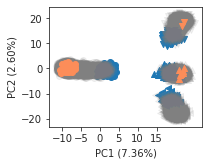

In [200]:
plt.figure(figsize=(3.,2.4))
markers = ["o","v","^","<"]
marker_dict = {label: marker for label, marker in zip(combined_index, markers)}
for label in combined_index:
    label_idxs = np.nonzero(model == label)[0]
    marker = marker_dict[label]
    this_idxs = {period: np.intersect1d(period_idxs[period], label_idxs) for period in all_periods}
    print(label_idxs.shape)
    # plt.scatter(PCS[:,0],PCS[:,1],color='grey',alpha=0.2)
    # prior_idxs = np.intersect1d(label_idxs, period_idxs["prior"])
    plt.scatter(PCS[this_idxs['Prior'],0],PCS[this_idxs['Prior'], 1],color='#1f78b4',label='Prior', marker=marker)
    plt.scatter(PCS[this_idxs["Intermediate"],0],PCS[this_idxs["Intermediate"], 1],
                color='grey',alpha=0.1,label='Intermediate',marker=marker)
    plt.scatter(PCS[this_idxs['Posterior'],0],PCS[this_idxs['Posterior'], 1],
                color='#fc8d59',label='Posterior',marker=marker)
plt.xlabel('PC1 ({:.2f}%)'.format(EV[0]*100))
plt.ylabel('PC2 ({:.2f}%)'.format(EV[1]*100))
# plt.legend(frameon=False,loc=(0.15,0.65),fontsize=8)
plt.xticks(np.arange(-10,20,5))
plt.tight_layout()
#plt.savefig('../figures/pca.pdf')
plt.savefig('../figures/pca.png',dpi=300)
plt.show()

In [121]:
marker_dict

{'prior': 'o', 'permuted_0': 'v', 'permuted_1': '^', 'permuted_2': '<'}